In [1]:
import tensorflow as tf
from tensorflow import keras

from __future__ import absolute_import, division, print_function, unicode_literals

from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout, Input, Activation, InputLayer, Reshape
from keras.callbacks import ModelCheckpoint
import numpy as np

from art.attacks import DeepFool, CarliniL2Method, CarliniLInfMethod, ElasticNet
from art.classifiers import KerasClassifier
from art.utils import load_dataset

Using TensorFlow backend.


In [2]:
import pandas as pd
import numpy as np
from scipy.stats import entropy
import sys
sys.path.append('..')
sys.path.append('../odcd/cd/')
sys.path.append('../odcd/utils/')
import matplotlib
import seaborn as sns
from creme.stats import Mean, Var
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, EarlyStopping
import model_symmetries as vsf
%matplotlib inline

from skmultiflow.drift_detection.adwin import ADWIN
from scipy.stats import percentileofscore

import streaming_sim_test as sst
from importlib import reload

import colorama
from colorama import Fore, Style
from keras import backend as K
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from inspect import signature

In [3]:
def _calculate_perc(df_t, nb_sigmas=3):
    sigma_plus = df_t['test'].mean() + (nb_sigmas * df_t['test'].std())
    pc_sigma = percentileofscore(df_t['adv'], sigma_plus) * 0.01
    perc = 1 - pc_sigma
    print(sigma_plus, pc_sigma)
    return perc, sigma_plus

def calculate_perc_nn(X_train, X_test, X_test_adv, predict_fn, nb_samples=100, nb_sigmas=3):
    
    X_train_samples = np.random.permutation(X_train)[:nb_samples]
    preds_train = predict_fn(X_train_samples)
    nn = NearestNeighbors()
    nn.fit(preds_train)
    
    preds_test, preds_adv = predict_fn(X_test), predict_fn(X_test_adv)
    dist_test, idx_test = nn.kneighbors(preds_test, n_neighbors=1)
    dist_adv, idx_adv = nn.kneighbors(preds_adv, n_neighbors=1)

    df_dist = pd.DataFrame()
    df_dist['test'] = dist_test.flatten()
    df_dist['adv'] = dist_adv.flatten()
    
    perc, sigma_plus = _calculate_perc(df_dist, nb_sigmas=nb_sigmas)
    
    return perc, df_dist, sigma_plus

# Cifar

In [4]:

# Read CIFAR10 dataset
(X_train, y_train), (X_test, y_test), min_, max_ = load_dataset(str('cifar10'))
X_train, y_train = X_train, y_train
X_test, y_test = X_test[:500], y_test[:500]
im_shape = X_train[0].shape

# Create Keras convolutional neural network - basic architecture from Keras examples
# Source here: https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py
def model_cifar():
    x_in = Input(shape=(32, 32, 3))
    x = Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3),  activation='relu')(x_in)
    x = Conv2D(32, (3, 3),  activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(10, name='logits')(x)
    x_out = Activation('softmax')(x)
    
    cnn = Model(inputs=x_in, outputs=x_out)
    cnn.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])
    
    return cnn

def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.summary()
    
    return model

In [5]:
train = False

In [6]:
# Create classifier wrapper
if train:
    m = model_cifar()
    model = KerasClassifier(model=m, clip_values=(min_, max_))
    model.fit(X_train, y_train, nb_epochs=50, batch_size=128)
else:
    m = load_model('model_cifar.h5')
    model = KerasClassifier(model=m, clip_values=(min_, max_))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [7]:
y_test_adv = y_test

In [8]:
# Craft adversarial samples with DeepFool
#print('Create DeepFool attack')
#adv_crafter = DeepFool(model)

In [9]:
preds_tmp = model.predict(X_test)
preds_tmp

array([[6.37724716e-03, 3.13791643e-05, 8.01134138e-06, ...,
        4.97088418e-04, 7.48497376e-04, 2.62676651e-04],
       [9.82169652e-08, 1.92031832e-04, 5.65958009e-18, ...,
        1.06021205e-25, 9.99807894e-01, 3.86730683e-08],
       [5.11228107e-02, 1.00451335e-01, 4.44124879e-08, ...,
        3.66773417e-10, 8.41345549e-01, 6.99240202e-03],
       ...,
       [2.19901594e-05, 3.43183750e-12, 9.27197099e-01, ...,
        4.02262376e-04, 3.26791763e-07, 6.50646814e-10],
       [1.79440960e-08, 1.58756251e-15, 9.99999642e-01, ...,
        7.65148525e-16, 1.30388788e-14, 3.00490232e-17],
       [9.95394886e-01, 2.15837265e-10, 4.60445648e-03, ...,
        2.96059055e-14, 6.92188635e-08, 8.21189228e-11]], dtype=float32)

In [10]:
mean_confidence = model.predict(X_test).max(axis=1).mean()
mean_confidence

0.8831566

In [17]:
# Craft adversarial samples with Carlini
print('Create Carlini attack')
#adv_crafter = CarliniL2Method(model, confidence=mean_confidence)
adv_crafter = CarliniLInfMethod(model, X_train, 1000, confidence=mean_confidence, beta=0)

Create Carlini attack
800A


In [18]:
# Craft adversarial samples with Elastic net
#print('Create Elastic net attack')
#adv_crafter = ElasticNet(model)

In [19]:
print('Craft attack test examples')
print('Method', type(adv_crafter))
X_test_adv = adv_crafter.generate(X_test)
y_test_adv = y_test
print('Done')

Craft attack test examples
Method <class 'art.attacks.carlini.CarliniLInfMethod'>
7.537929210928269 14.047732505231686
0 7.537929210928269
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
6.060393090592697 14.045597466584923
0 6.060393090592697
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
4.995079465676099 14.04435961933699
0 4.995079465676099
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
3.6167669211785625 14.041579613483874
0 3.6167669211785625
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
2.270423492108743 14.038074975611973
0 2.270423492108743
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
1.2995368613032845 14.03537033533471
0 1.2995368613032845
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
0.7421317904945312 14.041148727842813
0 0.7421317904945312
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
0.7639628048054874 14.034610641718375
0 0.7639628048054874
+++++++++++++++++++++++++++++++++++++++++++

5.3142741322517395 14.132593157845168
0 5.3142741322517395
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
1.170393741130829 14.109592387886114
0 1.170393741130829
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
1.710591197013855 14.056066955783301
0 1.710591197013855
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
3.559590478738149 14.090709863574688
0 3.559590478738149
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
1.710591197013855 14.056066940253425
0 1.710591197013855
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
3.3637736439704895 14.119854742944163
0 3.3637736439704895
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
1.9551104605197906 14.103451308207406
0 1.9551104605197906
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
1.9551104605197906 14.103451303332896
0 1.9551104605197906
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
1.3739083409309387 14.169157168395664
0 1.3739083409309387
+++++

In [20]:
# Evaluate the classifier on the adversarial samples
preds = np.argmax(model.predict(X_test), axis=1)
acc = np.sum(preds == np.argmax(y_test, axis=1)) / y_test.shape[0]
preds_adv = np.argmax(model.predict(X_test_adv), axis=1)
acc_adv = np.sum(preds_adv == np.argmax(y_test_adv, axis=1)) / y_test_adv.shape[0]
print('Classifier before adversarial training')
print('Accuracy on test samples: ', acc)
print('Accuracy on adversarial samples: ', acc_adv)


Classifier before adversarial training
Accuracy on test samples:  0.81
Accuracy on adversarial samples:  0.126


Sample instance from the cifar data set.


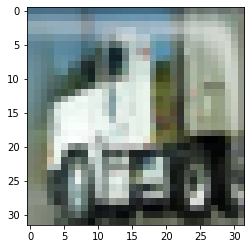

In [21]:
idx = 222
x = X_test[idx: idx + 1]
plt.imshow(np.squeeze(x))
print('Sample instance from the cifar data set.')

Sample instance from the cifar data set.


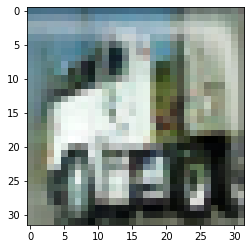

In [22]:
xa = X_test_adv[idx: idx + 1]
plt.imshow(np.squeeze(xa), 'gray')
print('Sample instance from the cifar data set.')

In [23]:
pred_x = m.predict(x)
pred_x

array([[1.1435114e-19, 4.1844677e-11, 4.0364861e-22, 1.1306498e-20,
        2.2380439e-24, 4.4517867e-22, 2.2469382e-26, 1.1734674e-20,
        5.9775433e-15, 1.0000000e+00]], dtype=float32)

In [24]:
pred_xa = m.predict(xa)
pred_xa

array([[4.7128695e-10, 8.6674082e-01, 6.4625735e-11, 4.8372928e-10,
        4.9071892e-12, 2.4473282e-10, 6.3844686e-11, 9.4881311e-11,
        1.7257862e-07, 1.3325903e-01]], dtype=float32)

In [25]:
np.allclose(m.predict(X_test), model.predict(X_test), 1e-4)

True

### nn detection on probability space

In [26]:
inp = m.input
outs = {l.name: l.output for l in m.layers}
predict_fns = {name: K.function([inp], [out]) for name, out in outs.items()}


In [27]:
def def_predict_fn(layer='softmax'):
    if layer == 'logits':
        def predict_fn(x):
            layer = predict_fns['logits']([x])
            return layer[0]
    elif layer == 'softmax':
        def predict_fn(x):
            return m.predict(x)
    return predict_fn

In [28]:
nbs = []
percs = []
predict_fn = def_predict_fn(layer='softmax')
for nb_samples in [100, 200, 300, 400, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]:
    print(nb_samples)
    perc, df_dist, sigma_plus = calculate_perc_nn(X_train, X_test, X_test_adv, predict_fn, 
                                                  nb_samples=nb_samples,  nb_sigmas=3)
    nbs.append(nb_samples)
    percs.append(perc)
    print(perc)
df_curve = pd.DataFrame()
df_curve['nb_samples'] = nbs
df_curve['percs'] = percs

100
0.6002217388641884 0.996
0.0040000000000000036
200
0.5596571386905492 0.9940000000000001
0.005999999999999894
300
0.4986070657859072 0.988
0.01200000000000001
400
0.454003159607495 0.98
0.020000000000000018
500
0.418672030547104 0.99
0.010000000000000009
1000
0.4013436018213751 0.9940000000000001
0.005999999999999894
1500
0.3613037293439489 0.99
0.010000000000000009
2000
0.3387751868748528 0.9840000000000001
0.015999999999999903
2500
0.3236794903520113 0.986
0.014000000000000012
3000
0.29703947811409526 0.9840000000000001
0.015999999999999903
3500
0.28241340162464124 0.986
0.014000000000000012
4000
0.28104559576585825 0.9820000000000001
0.017999999999999905
4500
0.2861993805226866 0.9720000000000001
0.027999999999999914
5000
0.2738210989947621 0.98
0.020000000000000018


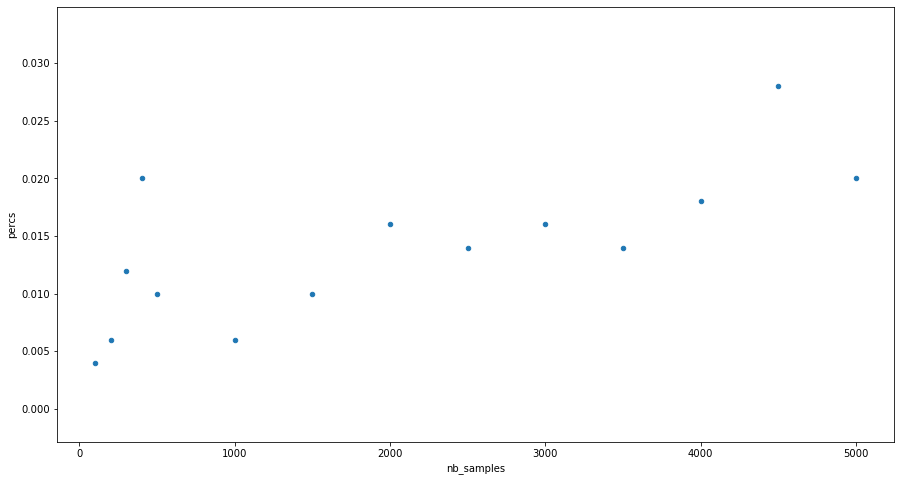

In [29]:
df_curve.plot(kind='scatter', x='nb_samples', y='percs', logx=False, figsize=(15, 8))

In [30]:
perc, df_dist, sigma_plus = calculate_perc_nn(X_train, X_test, X_test_adv, predict_fn, nb_samples=50000, nb_sigmas=3)
perc

0.15513291943443616 0.9720000000000001


0.027999999999999914

In [31]:
df_dist.describe(percentiles=[0.5, 0.9, perc])

,test,adv
count,5.000000e+02,5.000000e+02
mean,2.096869e-02,3.455780e-02
std,4.472141e-02,4.366425e-02
min,1.406089e-18,3.022150e-09
2.8%,8.510214e-12,5.059748e-05
50%,8.153074e-04,1.755639e-02
90%,7.841779e-02,9.340181e-02
max,3.617738e-01,2.478527e-01


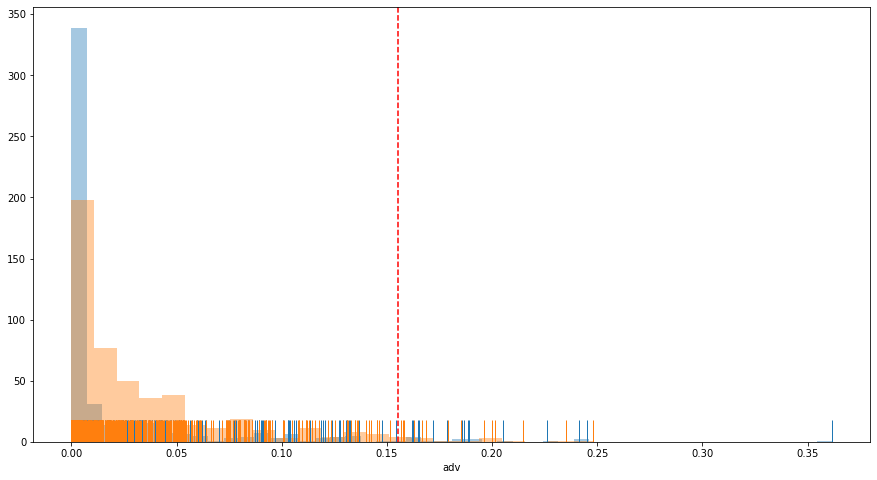

In [32]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.distplot(df_dist['test'], rug=True, ax=ax, kde=False)
plt.axvline(sigma_plus, c='r', linestyle='dashed')
sns.distplot(df_dist['adv'], rug=True,ax=ax, kde=False)

In [33]:
dist_test, dist_adv = df_dist['test'], df_dist['adv']

In [34]:
x_bl =  np.concatenate((dist_test, dist_adv))
y_bl = np.concatenate((np.zeros(len(dist_test)), np.ones(len(dist_adv))))
x_bl = x_bl / x_bl.max()

(0.0, 1.0)

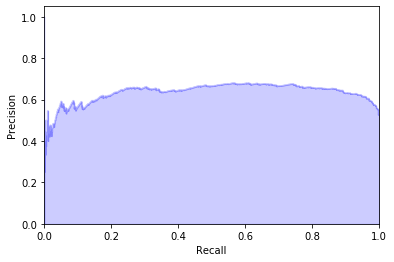

In [35]:

precision_bl, recall_bl, thresholds_bl = precision_recall_curve(y_bl, x_bl)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall_bl, precision_bl, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall_bl, precision_bl, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

## Detect through symmetry 

In [36]:
reload(vsf)

<module 'model_symmetries' from '../odcd/cd/model_symmetries.py'>

In [37]:
#model_layer = tf.keras.layers.Lambda(m.predict)

In [96]:
vae = vsf.VaeSymmetryFinderConvKeras(m, input_shape=(32, 32, 3), rgb_filters=3, dropout=0.2,
                                     intermediate_activation='relu', output_shape=(10, ), 
                                     nb_conv_layers=1, lr=0.001, filters=16, kernel_size=(4, 4),
                                     intermediate_dim=128, variational=False, opt='Adam', strides=2,
                                     latent_dim=2048, loss_type='kl_1', add_latent_loss=False)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 16, 16, 32)   1568        encoder_input[0][0]              
__________________________________________________________________________________________________
dropout_11 (Dropout)            (None, 16, 16, 32)   0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
flatten_6 (Flatten)             (None, 8192)         0           dropout_11[0][0]                 
__________________________________________________________________________________________________
z_mean (De

In [97]:
train = True

In [98]:
mcp = ModelCheckpoint('vae_weights_cifar_adv.h5', 
                      monitor='val_loss', 
                      verbose=1, 
                      save_best_only=True, 
                      save_weights_only=True, 
                      mode='auto', period=1)
es = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')

In [99]:
if train:
    vae.fit(X_train, x_test=X_test, epochs=150, callbacks=[mcp, es])
    vae.save(arch_path='vae_arch_cifar_adv.json', weights_path='vae_weights_cifar_adv_2.h5', save_model_only=True)

Train on 50000 samples, validate on 500 samples
Epoch 1/150
50000/50000 [==============================] - 12s 230us/step - loss: 2.1137 - val_loss: 1.3266

Epoch 00001: val_loss improved from inf to 1.32662, saving model to vae_weights_cifar_adv.h5
Epoch 2/150
50000/50000 [==============================] - 9s 177us/step - loss: 1.4850 - val_loss: 1.0876

Epoch 00002: val_loss improved from 1.32662 to 1.08763, saving model to vae_weights_cifar_adv.h5
Epoch 3/150
50000/50000 [==============================] - 9s 177us/step - loss: 1.3261 - val_loss: 0.9865

Epoch 00003: val_loss improved from 1.08763 to 0.98645, saving model to vae_weights_cifar_adv.h5
Epoch 4/150
50000/50000 [==============================] - 9s 178us/step - loss: 1.2028 - val_loss: 0.9662

Epoch 00004: val_loss improved from 0.98645 to 0.96618, saving model to vae_weights_cifar_adv.h5
Epoch 5/150
50000/50000 [==============================] - 9s 177us/step - loss: 1.1088 - val_loss: 0.9199

Epoch 00005: val_loss impro

In [100]:
#vae.save(arch_path='vae_arch_cifar_adv.json', weights_path='vae_weights_cifar_adv_2.h5', save_model_only=True)

In [101]:
vae_loaded = vsf.load_vae(arch_path='vae_arch_cifar_adv.json', 
                          weights_path='vae_weights_cifar_adv.h5', 
                          model_type='keras', signal_type='kl_1')
#vae_loaded = vae

Loaded model from disk


## Stream

In [102]:
# Symmetry signal
#X_train_perm = np.random.permutation(X_train)
#X_test_perm = np.random.permutation(X_test)
#X_adv_perm = np.random.permutation(X_adv)

amp = 1
kl_train = vae_loaded.signal(X_train, amp=amp)
idx_train = np.where((kl_train == np.inf) | (kl_train == np.nan))[0]
kl_train = np.delete(kl_train, idx, axis=0)

kl_test = vae_loaded.signal(X_test, amp=amp)
kl_adv = vae_loaded.signal(X_test_adv, amp=amp)

idx_test = np.where(kl_test == np.inf)[0]
kl_test = np.delete(kl_test, idx, axis=0)

kl_adv = np.delete(kl_adv, idx, axis=0)

baseline_std_plus = kl_train.mean() + kl_train.std()
baseline_std_minus = kl_train.mean() - kl_train.std()

kl_concat = np.concatenate((kl_test, kl_adv))
tr = kl_test.shape[0]

In [103]:
print(kl_train.shape, kl_test.shape, kl_adv.shape)

(49999,) (499,) (499,)


In [104]:
vae_loaded.predict_original(x)

array([[1.1435114e-19, 4.1844677e-11, 4.0364861e-22, 1.1306498e-20,
        2.2380439e-24, 4.4517867e-22, 2.2469382e-26, 1.1734674e-20,
        5.9775433e-15, 1.0000000e+00]], dtype=float32)

In [105]:
vae_loaded.transform_predict(x)

array([[6.4864886e-05, 1.0043788e-02, 1.0433258e-07, 2.1598638e-05,
        7.3940343e-10, 1.6583104e-05, 1.4775045e-06, 1.1585524e-06,
        2.0188862e-05, 9.8983020e-01]], dtype=float32)

In [106]:
vae_loaded.predict_original(xa)

array([[4.7128695e-10, 8.6674082e-01, 6.4625735e-11, 4.8372928e-10,
        4.9071892e-12, 2.4473282e-10, 6.3844686e-11, 9.4881311e-11,
        1.7257862e-07, 1.3325903e-01]], dtype=float32)

In [107]:
vae_loaded.transform_predict(xa)

array([[1.2522614e-04, 1.8856311e-02, 2.2764434e-07, 2.9919032e-05,
        1.4778994e-09, 2.3343317e-05, 3.3837409e-06, 1.4451979e-06,
        4.2486998e-05, 9.8091769e-01]], dtype=float32)

In [108]:
print(kl_train.mean(), kl_train.std())

0.6997171 0.77758557


In [109]:
print(kl_test.mean(), kl_test.std())

0.82085043 0.87964296


In [110]:
print(kl_adv.mean(), kl_adv.std())

1.7271663 1.5972496


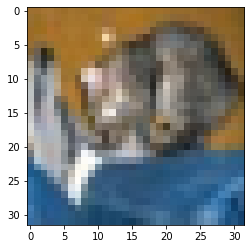

In [111]:
plt.imshow(np.squeeze(X_test[0]))

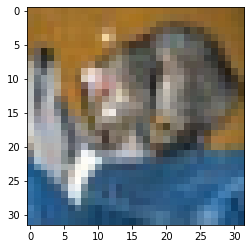

In [112]:
plt.imshow(np.squeeze(X_test_adv[0]))

### Detector curves

In [159]:
perm = np.random.permutation(range(len(kl_adv)))[:200]
perm

array([427, 325,  80, 185,  11,  21, 381, 314, 151, 456, 324, 483, 235,
        98, 482, 485, 128, 478, 442, 317, 180, 301, 343,  44,  27, 493,
       264,  36, 418, 452, 277, 113, 138, 182, 172, 221, 210, 268, 207,
       232,  31, 349, 323, 397, 267, 133, 454, 416,  65, 310, 450,   5,
       458, 319,  95,  83, 333, 290, 369,  29, 464, 403,  90,  47, 215,
       186,  15, 411, 181, 104, 484,  25, 357, 261, 332, 365,   1,  70,
       340, 106, 130, 148, 116,  87, 461, 219, 135, 395, 205, 203, 107,
       168,  50, 419, 377, 117,  24, 286, 330, 124, 438,  46, 445, 346,
        82, 166,  22, 394,  53, 432, 123, 463, 282, 436, 476, 163, 496,
       204,  79, 399, 234, 167, 260,  48, 444, 358, 256, 370,  58, 401,
       338, 250,  63, 329, 362, 353,  73, 169,  68, 429, 245, 389, 145,
       318, 244, 174, 481, 141,  88, 392, 344, 160, 384, 443, 405, 152,
       457, 296, 473,  26, 247, 103, 446, 131,  51, 285, 271, 367, 229,
       426, 281, 303,  66, 360, 495,  57,  49, 144, 292, 335, 11

In [160]:
x_kl = np.concatenate((kl_test, kl_adv[perm]))
y_kl = np.concatenate((np.zeros(len(kl_test)), np.ones(len(kl_adv[perm]))))
x_kl = x_kl / x_kl.max()

In [161]:
X_train_samples = np.random.permutation(X_train)[:2500]
preds_train = predict_fn(X_train_samples)
nn = NearestNeighbors()
nn.fit(preds_train)
    
preds_test, preds_adv = predict_fn(X_test), predict_fn(X_test_adv)
dist_test, idx_test = nn.kneighbors(preds_test, n_neighbors=1)
dist_adv, idx_adv = nn.kneighbors(preds_adv, n_neighbors=1)

In [162]:
x_bl =  np.concatenate((dist_test, dist_adv[perm]))
y_bl = np.concatenate((np.zeros(len(dist_test)), np.ones(len(dist_adv[perm]))))
x_bl = x_bl / x_bl.max()

(0.0, 1.0)

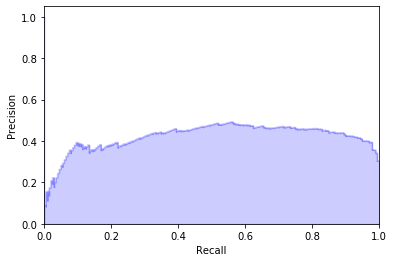

In [163]:

precision_bl, recall_bl, thresholds_bl = precision_recall_curve(y_bl, x_bl)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall_bl, precision_bl, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall_bl, precision_bl, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

(0.0, 1.0)

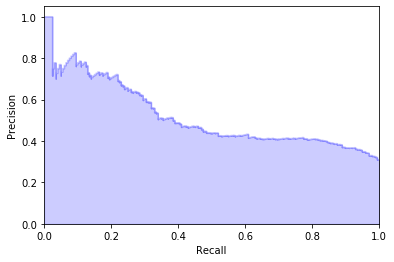

In [164]:
precision, recall, thresholds = precision_recall_curve(y_kl, x_kl)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

In [165]:
min_train = kl_train.mean()
max_train = kl_train.mean() + 10 * kl_train.std()
min_bl = dist_test.mean()
max_bl = dist_adv.mean() + 10 * dist_adv.std()
print(max_train, max_bl)

8.475572764873505 0.8357304562374039


In [166]:
trs = np.arange(0, max_train, 0.005)

In [167]:
def predict_adv(x, tr):
    return (x >= tr).astype(int)

In [168]:
tresholds, precs, recals, accs = [], [], [], []
precs_bl, recals_bl, accs_bl = [], [], []
for tr in trs:
    preds_kl = predict_adv(x_kl, tr)
    preds_bl = predict_adv(x_bl, tr)
    
    prec = precision_score(y_kl, preds_kl)
    rec = recall_score(y_kl, preds_kl)
    acc= accuracy_score(y_kl, preds_kl)

    prec_bl = precision_score(y_bl, preds_bl)
    rec_bl = recall_score(y_bl, preds_bl)
    acc_bl = accuracy_score(y_bl, preds_bl)
    
    tresholds.append(tr)
    precs.append(prec)
    recals.append(rec)
    accs.append(acc)
    
    precs_bl.append(prec_bl)
    recals_bl.append(rec_bl)
    accs_bl.append(acc_bl)


df_scores = pd.DataFrame()
df_scores['trs'] = tresholds
df_scores['precs'] = precs
df_scores['recs'] = recals
df_scores['accs'] = accs

df_scores['precs_bl'] = precs_bl
df_scores['recs_bl'] = recals_bl
df_scores['accs_bl'] = accs_bl

/home/Gigio/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


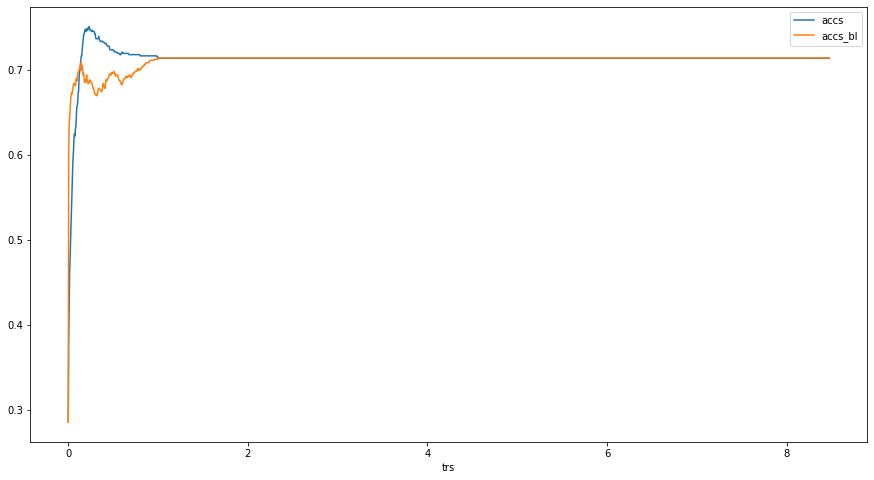

In [169]:
df_scores.plot(x= 'trs',y=['accs', 'accs_bl'], figsize=(15, 8))

In [170]:
df_scores.describe()

,trs,precs,recs,accs,precs_bl,recs_bl,accs_bl
count,1696.000000,1696.000000,1696.000000,1696.000000,1696.000000,1696.000000,1696.000000
mean,4.237500,0.093736,0.019959,0.712963,0.031936,0.024186,0.711359
std,2.448687,0.265665,0.102745,0.021770,0.105934,0.109341,0.013601
min,0.000000,0.000000,0.000000,0.286123,0.000000,0.000000,0.285714
25%,2.118750,0.000000,0.000000,0.713877,0.000000,0.000000,0.714286
50%,4.237500,0.000000,0.000000,0.713877,0.000000,0.000000,0.714286
75%,6.356250,0.000000,0.000000,0.713877,0.000000,0.000000,0.714286
max,8.475000,1.000000,1.000000,0.751073,0.491304,1.000000,0.714286


In [171]:
df_scores[df_scores['precs'] == df_scores['precs'].max()]

,trs,precs,recs,accs,precs_bl,recs_bl,accs_bl
120,0.600,1.0,0.025,0.721030,0.176471,0.030,0.682857
121,0.605,1.0,0.025,0.721030,0.181818,0.030,0.684286
122,0.610,1.0,0.020,0.719599,0.193548,0.030,0.687143
123,0.615,1.0,0.020,0.719599,0.200000,0.030,0.688571
124,0.620,1.0,0.020,0.719599,0.206897,0.030,0.690000
125,0.625,1.0,0.020,0.719599,0.206897,0.030,0.690000
126,0.630,1.0,0.020,0.719599,0.206897,0.030,0.690000
127,0.635,1.0,0.020,0.719599,0.206897,0.030,0.690000
128,0.640,1.0,0.020,0.719599,0.214286,0.030,0.691429
129,0.645,1.0,0.020,0.719599,0.222222,0.030,0.692857


In [172]:
np.squeeze(predict_adv(x_bl, 0.015))

array([1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,

In [173]:
predict_adv(x_kl, 4.9)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### Signal histograms

In [151]:
df_kl = pd.DataFrame()
df_kl['test'] = kl_test
df_kl['adv'] = kl_adv

In [152]:
df_kl.dropna(inplace=True)

In [153]:
def _calculate_perc(df_t, nb_sigmas=3):
    sigma_plus = df_t['test'].mean() + (nb_sigmas * df_t['test'].std())
    print(df_t['test'].mean())
    pc_sigma = percentileofscore(df_t['adv'], sigma_plus) * 0.01
    perc = 1 - pc_sigma
    print(sigma_plus, pc_sigma)
    return perc, sigma_plus

In [154]:
df_kl = df_kl[~(df_kl['test'] == np.inf)]

In [155]:
prec, sigma_plus = _calculate_perc(df_kl, nb_sigmas=3)

0.8208509087562561
3.462427496910095 0.8857715430861725


In [156]:
prec

0.11422845691382755

In [157]:
df_kl.describe(percentiles=[0.5, 0.9, prec])

,test,adv
count,499.000000,499.000000
mean,0.820851,1.727165
std,0.880526,1.598852
min,0.000030,0.035179
11.4%,0.039563,0.372240
50%,0.577391,1.207104
90%,1.803790,3.672013
max,6.446587,10.771723


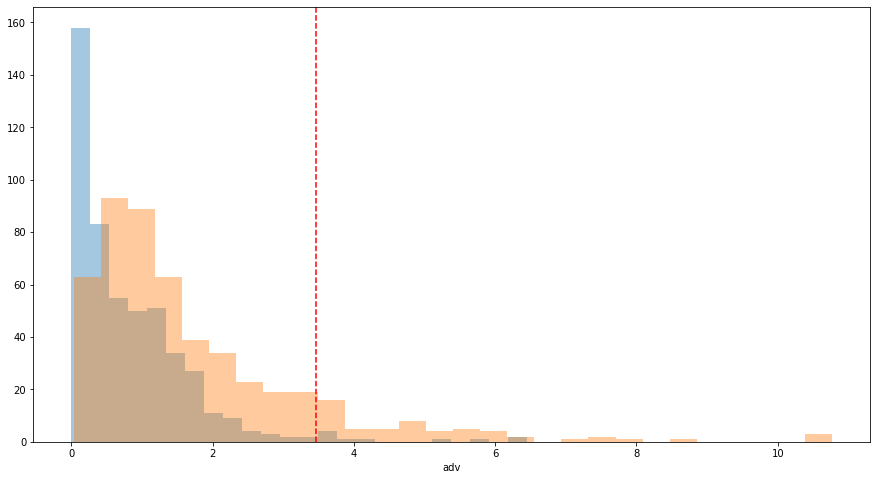

In [158]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.distplot(df_kl['test'], ax=ax, kde=False)
sns.distplot(df_kl['adv'], ax=ax, kde=False)
plt.axvline(sigma_plus, c='r', linestyle='dashed')

### Sudden drift

In [176]:
df = sst.make_data_stream(kl_concat, agg='mean')

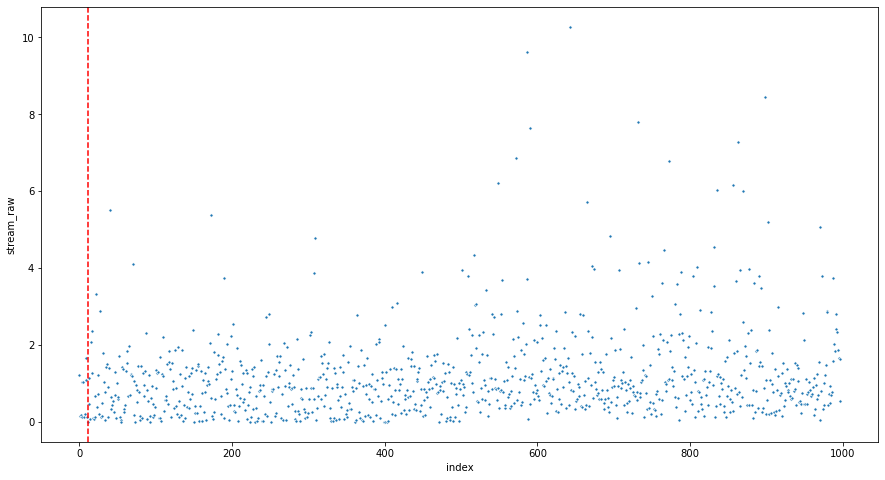

In [177]:
plt.figure(figsize=(15,8))
sns.scatterplot( x="index", y="stream_raw", data=df.reset_index(), s=10)
ax.set(ylim=(-0.1, None))
plt.axvline(tr, c='r', linestyle='dashed')

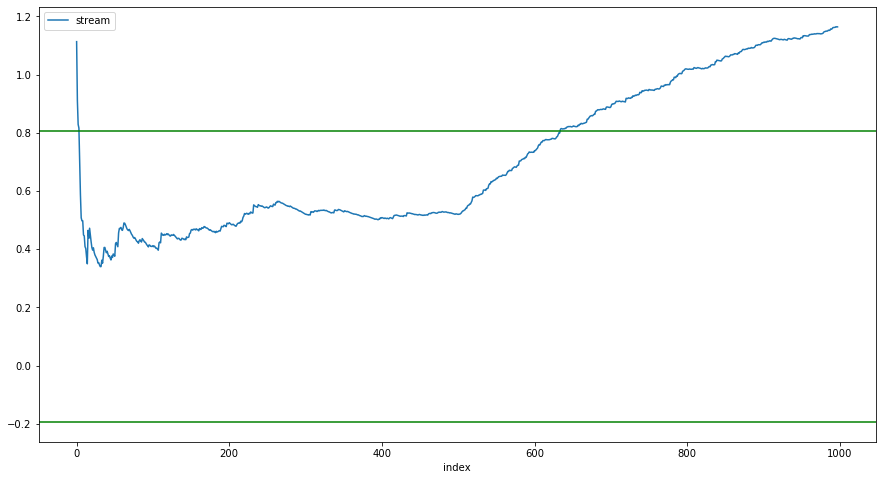

In [201]:
ax = df.plot(x='index', y='stream', figsize=(15,8))
ax.axhline(baseline_std_plus / amp, c='g')
ax.axhline(baseline_std_minus / amp, c='g')

In [202]:
adwin = ADWIN(delta=0.002)
data_stream = df['stream']
for i in range(len(data_stream)):
    adwin.add_element(data_stream[i])
    if adwin.detected_change():
        if i < tr:
            print(Fore.RED + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))
        else:
            print(Fore.GREEN + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))

Change detected in data: 0.5401796529473015 - at index: 511
Change detected in data: 0.6822066814667476 - at index: 575
Change detected in data: 0.7582390076924733 - at index: 607
Change detected in data: 0.8134401251238611 - at index: 639
Change detected in data: 0.8504388143355319 - at index: 671
Change detected in data: 0.8985290835444586 - at index: 703
Change detected in data: 0.9308849070718241 - at index: 735
Change detected in data: 0.9597826829986309 - at index: 767
Change detected in data: 1.0192112621936027 - at index: 799
Change detected in data: 1.0716164376173634 - at index: 863
Change detected in data: 1.1022652927820225 - at index: 895
Change detected in data: 1.1209546929210088 - at index: 927


### Gradual drift

In [203]:
cd_start = 2000
cd_full = int(2 * cd_start)
nb_samples_tot = 6000
start = 0
df = sst.rolling_stats(vae_loaded, X_test, y_test, X_test_adv, y_test_adv, cd_start, cd_full, nb_samples_tot, start, amp=amp)

Sample 0 of 6000
Sample 1000 of 6000
Sample 2000 of 6000
Sample 3000 of 6000
Sample 4000 of 6000
Sample 5000 of 6000


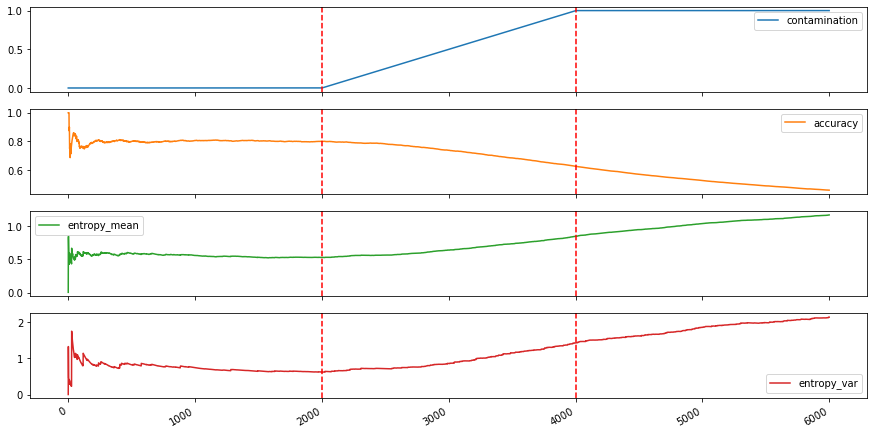

In [204]:
axs = df[['contamination', 'accuracy','entropy_mean', 'entropy_var']].plot(logy = False, subplots=True, figsize = (15, 8))
for ax in axs:
    ax.axvline(cd_start, c='r', linestyle='dashed')
    ax.axvline(cd_full, c='r', linestyle='dashed')

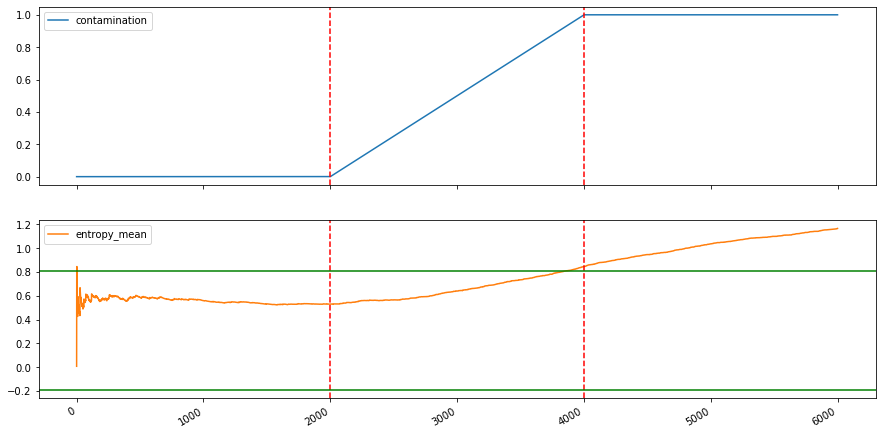

In [205]:
axs = df[['contamination', 'entropy_mean']].plot(logy = False, subplots=True, figsize = (15, 8))
for ax in axs:
    ax.axvline(cd_start, c='r', linestyle='dashed')
    ax.axvline(cd_full, c='r', linestyle='dashed')
axs[1].axhline(baseline_std_plus / amp, c='g')
axs[1].axhline(baseline_std_minus / amp, c='g')


In [206]:
data_stream = df['entropy_mean']
adwin = ADWIN(delta=0.002)
for i in range(len(data_stream)):
    adwin.add_element(data_stream[i])
    if adwin.detected_change():
        if i < cd_start:
            print(Fore.RED + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))
        elif i >= cd_start and i < cd_full:
            print(Fore.YELLOW + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))            
        else:
            print(Fore.GREEN + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))

Change detected in data: 0.5375337966745662 - at index: 1439
Change detected in data: 0.5316391702410632 - at index: 1503
Change detected in data: 0.5266726294170965 - at index: 1535
Change detected in data: 0.5254331860330516 - at index: 1663
Change detected in data: 0.5315599386247658 - at index: 1855
Change detected in data: 0.6201501712602411 - at index: 2879
Change detected in data: 0.6370116725942838 - at index: 2975
Change detected in data: 0.6394121545831225 - at index: 3007
Change detected in data: 0.6503838178987293 - at index: 3071
Change detected in data: 0.6620899489253705 - at index: 3135
Change detected in data: 0.6745116069274095 - at index: 3199
Change detected in data: 0.7014724541365065 - at index: 3327
Change detected in data: 0.7265486242066042 - at index: 3455
Change detected in data: 0.7488900870078931 - at index: 3583
Change detected in data: 0.773783634530792 - at index: 3711
Change detected in data: 0.8038587495568219 - at index: 3839
Change detected in data: 

/home/Gigio/anaconda3/lib/python3.6/site-packages/skmultiflow/drift_detection/adwin.py:361: RuntimeWarning: invalid value encountered in sqrt
  epsilon = np.sqrt(2 * m * v * dd) + 1. * 2 / 3 * dd * m


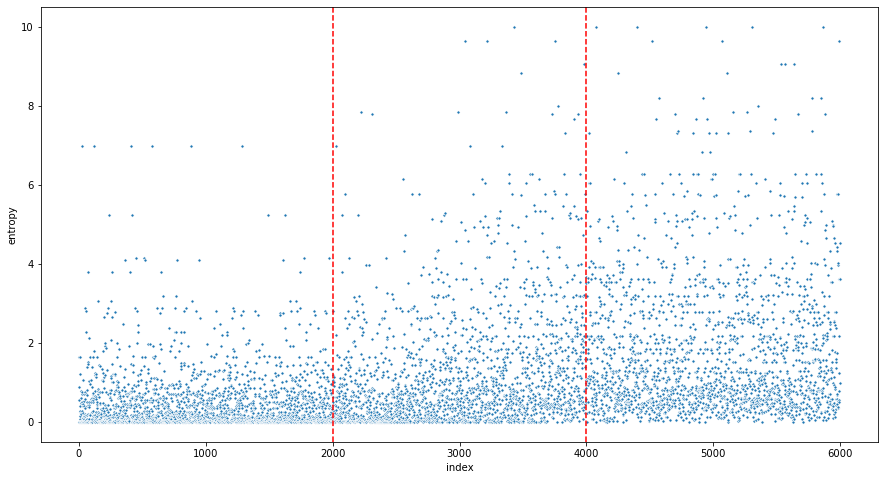

In [207]:
plt.figure(figsize=(15,8))
sns.scatterplot( x="index", y="entropy", data=df.reset_index(), s=10)
ax.set(ylim=(-0.1, None))
plt.axvline(cd_start, c='r', linestyle='dashed')
plt.axvline(cd_full, c='r', linestyle='dashed')